## 知識情報学第6回演習サンプルプログラム ex6.ipynb
- Programmed by Wu Hongle, 監修　福井健一
- Last updated: 2023/11/06
- Checked with Python 3.8.16, scikit-learn 1.2.1
- MIT Lisence

## SVMによるBreast Cancerデータの識別
- 入れ子交差検証で最適パラメータを探索

In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import scale

### Breast Cancerデータのロード

In [2]:
df = load_breast_cancer()
X = df.data
y = df.target

# z標準化
X = scale(X)

In [3]:
print(df.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

### 入れ子交差検証でハイパーパラメータを最適化
- 【課題1】探索するパラメータにカーネル関数の追加や範囲を変更して最適パラメータを探してみましょう
    - グリッドサーチパラメータリストの書き方は下記を参照
        - https://scikit-learn.org/stable/modules/grid_search.html#grid-search
    - SVCの可能なパラメータリストは下記を参照
        - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
- 【課題2】Optunaを利用してハイパーパラメータを最適化し，グリッドサーチと比較してみましょう．
    - Optuna: https://optuna.org
    - 使い方は，Code Exmaplesを参照
    - グリッドサーチ同様に入れ子の交差検証を用いること
    - optunaでパラメータの生成範囲指定は下記を参照（関数 suggest_***）
        - https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial
- 【課題3】最適なカーネル関数およびハイパーパラメータ，そこから分かるデータの特徴について考察してみましょう．

In [4]:
# 外側ループのための交差検証用データ生成インスタンス
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

acc_trn_list = []  #外側ループのfold毎の学習データに対するaccuracy格納用
acc_tst_list = []  #外側ループのfold毎のテストデータに対するaccuracy格納用

# グリッドサーチのパラメータリスト
parameters = {'kernel':['poly','rbf','sigmoid'], 
                      'gamma':[0.001, 0.01, 0.1, 1, 10, 100], 
                      'degree':[1,2,3,4], 
                      'coef0':[1,5,10]
                      } 
# 内側ループでグリッドサーチを行う交差検証インスタンス
gs = GridSearchCV(SVC(), parameters, cv=2) 

k=0
for train_itr, test_itr in kfold.split(X, y):
    # 内側ループのグリッドサーチ
    gs.fit(X[train_itr], y[train_itr])
    print('Fold #{:2d}; Best Parameter: {}, Accuracy: {:.3f}'\
        .format(k+1,gs.best_params_,gs.best_score_))
    acc_trn_list.append(gs.score(X[train_itr],y[train_itr]))
    acc_tst_list.append(gs.score(X[test_itr],y[test_itr]))
    k=k+1

Fold # 1; Best Parameter: {'coef0': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}, Accuracy: 0.979
Fold # 2; Best Parameter: {'coef0': 1, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}, Accuracy: 0.971
Fold # 3; Best Parameter: {'coef0': 5, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}, Accuracy: 0.975
Fold # 4; Best Parameter: {'coef0': 1, 'degree': 1, 'gamma': 1, 'kernel': 'poly'}, Accuracy: 0.973
Fold # 5; Best Parameter: {'coef0': 1, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}, Accuracy: 0.973
Fold # 6; Best Parameter: {'coef0': 1, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}, Accuracy: 0.979
Fold # 7; Best Parameter: {'coef0': 5, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}, Accuracy: 0.977
Fold # 8; Best Parameter: {'coef0': 5, 'degree': 3, 'gamma': 0.001, 'kernel': 'poly'}, Accuracy: 0.979
Fold # 9; Best Parameter: {'coef0': 5, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}, Accuracy: 0.971
Fold #10; Best Parameter: {'coef0': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}, Accur

### 平均Accuracy

In [5]:
print('Training data: %1.3f' % np.mean(acc_trn_list))
print('Test data: %1.3f' % np.mean(acc_tst_list))

Training data: 0.986
Test data: 0.974


### 2次元に圧縮して識別境界面を描画してみる

In [6]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [7]:
# 主成分分析で2次元に圧縮
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 描画のためのメッシュを定義
x1_min, x1_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
x2_min, x2_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02), np.arange(x2_min, x2_max, 0.02))

In [8]:
def plot_decision_boundary(Z1): 
    Z1 = Z1.reshape(xx1.shape)

    markers = ('s', 'x')
    colors = ('red', 'blue')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    plt.contourf(xx1, xx2, Z1, alpha=0.5, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X_pca[y == cl, 0], y=X_pca[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl)

    plt.xlabel('pca1')
    plt.ylabel('pca2')

    plt.show()

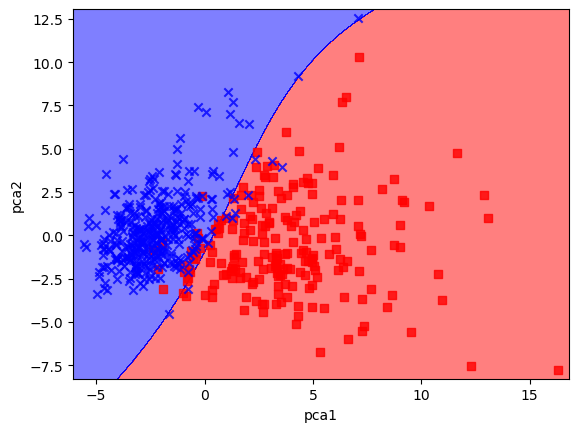

In [9]:
svc = SVC(kernel='rbf', gamma=0.01)
svc.fit(X_pca, y)
Z = svc.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
plot_decision_boundary(Z)

### scikit-learnのDecisionBoundaryDisplayを使用する場合
- https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html
- sklearn 1.1以上

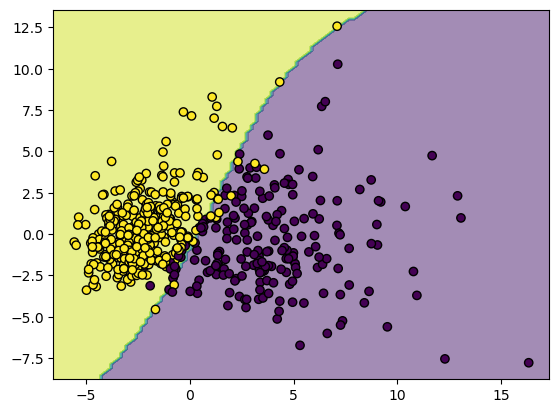

In [10]:
from sklearn.inspection import DecisionBoundaryDisplay

svc = SVC(kernel='rbf', gamma=0.01)
svc.fit(X_pca, y)
display = DecisionBoundaryDisplay.from_estimator(svc, X_pca, response_method="predict", alpha=0.5)

display.ax_.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor="black")
plt.show()